## Load 'jupyter notebook' from Conda Terminal before beginning to use GPU

In [1]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.optimizers import SGD
import numpy as np
import tensorflow as tf
from keras.models import load_model


# Testing to make sure TensorFlow GPU is working
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Tensorflow: ', tf.__version__)

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17466363671954521762
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4952306483
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6641045901166123404
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Tensorflow:  1.11.0


### Load data, shuffle data, normalize data, split data into training and validation

In [2]:
from sklearn.utils import shuffle

# Load the data
X_train = np.load("X_melnew_train_3.dat")
y_train = np.load("y_melnew_train_3.dat")

print(X_train)


X_train, y_train = shuffle(X_train, y_train, random_state=16)
# reshape so in form for CNN-Keras
#X_train = X_train.reshape(X_train.shape[0], 174, 124, 1)

# Normalize the data
# X_train = X_train/255

print(X_train.shape)
print(y_train.shape)


# split data into validation set
training_set_size = int(X_train.shape[0] * .80)
X_train_validation = X_train[training_set_size:, :,:,:]
y_train_validation = y_train[training_set_size:, :]
y_train = y_train[:training_set_size,:]
X_train = X_train[:training_set_size, :, :, :]
print("Validation x train set:" + str(X_train_validation.shape))
print("X train set:" + str(X_train.shape))
print("Validation y train set:" + str(y_train_validation.shape))
print("Y train set:" + str(y_train.shape))

[[2175.02383311 2103.86995762 1955.28566681 ... 4031.3645376
  3856.51368531 3270.84446624]
 [2570.77299051 2533.11347523 2451.78178665 ... 1849.5708254
  1685.14410446 1589.4784735 ]
 [1635.23782519 1523.11687881 1369.41189919 ... 1503.12816303
  1483.58459923 1365.20503472]
 ...
 [3535.57191916 2462.27935639 1529.4621064  ...  874.58988997
   839.80340766  814.89165223]
 [ 749.24281579 1764.1412354  2563.01131115 ... 1431.25337975
  1311.69600294 1063.08285373]
 [ 980.470122   1030.84782814 1130.95585045 ...  969.65235904
   928.0298142   893.33106738]]
(8996, 130)
(8996, 10)


IndexError: too many indices for array

## Build the CNN network

In [10]:
# VGG-16 like network from Andrew Ng's course on Coursera
def build_model():
    model = Sequential()

    # input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
    # this applies 32 convolution filters of size 3x3 each.
    model.add(BatchNormalization(input_shape=X_train.shape[1:]))
    
    model.add(Conv2D(64, (7,7), activation = 'relu', strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))

    model.add(Conv2D(128, (7,7), activation = 'relu', strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())    
    # model.add(Dropout(0.5))

    model.add(Conv2D(256, (7,7), activation = 'relu', strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))

#     model.add(Conv2D(512, (2,2), activation = 'relu', strides=(1,1)))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))

    # model.add(Conv2D(256, (7, 7), activation = 'relu', strides=(1,1)))
    # # # model.add(BatchNormalization())
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # # # model.add(Dropout(0.5))

    # # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

## Begin training the model

In [11]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

mcp = ModelCheckpoint("models/best_model_3splits_mel.h5", monitor='val_acc', verbose=0, 
                      save_best_only=True, save_weights_only=False, mode='max', period=1)

# do crazy image generator stuff to randomize data
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10
                        )
generator = gen.flow(X_train, y_train, batch_size = 32)
# end of crazy image genertor stuff


# adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model = build_model()
model.compile(sgd, 'categorical_crossentropy',metrics=['accuracy'])

model.fit_generator(generator, steps_per_epoch=len(X_train)/32, epochs=1000, validation_data=(X_train_validation, y_train_validation), 
         callbacks = [mcp])

Epoch 1/1000
225/225 [==============================] - 51s 229ms/step - loss: 2.3905 - acc: 0.3136 - val_loss: 1.8831 - val_acc: 0.4156
Epoch 2/1000
225/225 [==============================] - 48s 215ms/step - loss: 1.9087 - acc: 0.3936 - val_loss: 2.1276 - val_acc: 0.3189
Epoch 3/1000
225/225 [==============================] - 48s 214ms/step - loss: 1.6886 - acc: 0.4383 - val_loss: 1.5556 - val_acc: 0.4711
Epoch 4/1000
225/225 [==============================] - 48s 215ms/step - loss: 1.5658 - acc: 0.4700 - val_loss: 1.5575 - val_acc: 0.4561
Epoch 5/1000
225/225 [==============================] - 48s 214ms/step - loss: 1.4951 - acc: 0.4889 - val_loss: 1.6308 - val_acc: 0.4244
Epoch 6/1000
225/225 [==============================] - 48s 214ms/step - loss: 1.4244 - acc: 0.5136 - val_loss: 1.5942 - val_acc: 0.4400
Epoch 7/1000
225/225 [==============================] - 48s 215ms/step - loss: 1.3917 - acc: 0.5324 - val_loss: 1.4692 - val_acc: 0.4900
Epoch 8/1000
225/225 [===================

225/225 [==============================] - 48s 214ms/step - loss: 0.5685 - acc: 0.8065 - val_loss: 1.6139 - val_acc: 0.5778
Epoch 120/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.5754 - acc: 0.7982 - val_loss: 1.3688 - val_acc: 0.6533
Epoch 121/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.5682 - acc: 0.8031 - val_loss: 1.0769 - val_acc: 0.6967
Epoch 122/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.5623 - acc: 0.8015 - val_loss: 1.1406 - val_acc: 0.6950
Epoch 123/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.5746 - acc: 0.8003 - val_loss: 0.9058 - val_acc: 0.7300
Epoch 124/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.5379 - acc: 0.8136 - val_loss: 1.1451 - val_acc: 0.6872
Epoch 125/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.5527 - acc: 0.8081 - val_loss: 1.0446 - val_acc: 0.7039
Epoch 126/1000
225/225 [==================

225/225 [==============================] - 48s 214ms/step - loss: 0.4389 - acc: 0.8500 - val_loss: 0.8516 - val_acc: 0.7567
Epoch 179/1000
225/225 [==============================] - 48s 213ms/step - loss: 0.4409 - acc: 0.8483 - val_loss: 0.8659 - val_acc: 0.7583
Epoch 180/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.4186 - acc: 0.8581 - val_loss: 1.1965 - val_acc: 0.6989
Epoch 181/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.4303 - acc: 0.8528 - val_loss: 1.1884 - val_acc: 0.7111
Epoch 182/1000
225/225 [==============================] - 48s 215ms/step - loss: 0.4307 - acc: 0.8465 - val_loss: 1.0294 - val_acc: 0.7233
Epoch 183/1000
225/225 [==============================] - 48s 215ms/step - loss: 0.4336 - acc: 0.8514 - val_loss: 1.0425 - val_acc: 0.7294
Epoch 184/1000
225/225 [==============================] - 48s 215ms/step - loss: 0.4190 - acc: 0.8542 - val_loss: 1.0979 - val_acc: 0.7183
Epoch 185/1000
225/225 [==================

225/225 [==============================] - 48s 214ms/step - loss: 0.3203 - acc: 0.8883 - val_loss: 0.8016 - val_acc: 0.7883
Epoch 238/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.3215 - acc: 0.8904 - val_loss: 0.8553 - val_acc: 0.7828
Epoch 239/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.3236 - acc: 0.8903 - val_loss: 1.0762 - val_acc: 0.7528
Epoch 240/1000
225/225 [==============================] - 48s 215ms/step - loss: 0.3268 - acc: 0.8886 - val_loss: 0.8395 - val_acc: 0.7733
Epoch 241/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.3352 - acc: 0.8853 - val_loss: 0.9474 - val_acc: 0.7628
Epoch 242/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.3207 - acc: 0.8897 - val_loss: 1.0996 - val_acc: 0.7417
Epoch 243/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.3300 - acc: 0.8861 - val_loss: 0.9944 - val_acc: 0.7672
Epoch 244/1000
225/225 [==================

225/225 [==============================] - 48s 214ms/step - loss: 0.2645 - acc: 0.9082 - val_loss: 1.4556 - val_acc: 0.6994
Epoch 297/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.2656 - acc: 0.9056 - val_loss: 1.1653 - val_acc: 0.7483
Epoch 298/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.2571 - acc: 0.9117 - val_loss: 0.9150 - val_acc: 0.7872
Epoch 299/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.2588 - acc: 0.9067 - val_loss: 0.9287 - val_acc: 0.7872
Epoch 300/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.2706 - acc: 0.9031 - val_loss: 0.8955 - val_acc: 0.7861
Epoch 301/1000
225/225 [==============================] - 48s 214ms/step - loss: 0.2697 - acc: 0.9064 - val_loss: 1.4051 - val_acc: 0.7317
Epoch 302/1000
225/225 [==============================] - 48s 215ms/step - loss: 0.2659 - acc: 0.9035 - val_loss: 1.2167 - val_acc: 0.7494
Epoch 303/1000
225/225 [==================

 36/225 [===>..........................] - ETA: 28s - loss: 0.2023 - acc: 0.9314

KeyboardInterrupt: 

# Delete the below cell

In [7]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

mcp = ModelCheckpoint("models/best_model_3splits_mel.h5", monitor='val_acc', verbose=0, 
                      save_best_only=True, save_weights_only=False, mode='max', period=1)

# do crazy image generator stuff to randomize data
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10
                        )
generator = gen.flow(X_train, y_train, batch_size = 32)
# end of crazy image genertor stuff


# adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model = load_model("models/best_model_3splits_mel.h5")
model.compile(sgd, 'categorical_crossentropy',metrics=['accuracy'])

model.fit_generator(generator, steps_per_epoch=len(X_train)/32, epochs=100, validation_data=(X_train_validation, y_train_validation), 
         callbacks = [mcp])

Epoch 1/100
225/225 [==============================] - 54s 238ms/step - loss: 0.5521 - acc: 0.8147 - val_loss: 0.7215 - val_acc: 0.7583
Epoch 2/100
225/225 [==============================] - 49s 216ms/step - loss: 0.5568 - acc: 0.8189 - val_loss: 0.6804 - val_acc: 0.7694
Epoch 3/100
225/225 [==============================] - 49s 217ms/step - loss: 0.5533 - acc: 0.8149 - val_loss: 0.7528 - val_acc: 0.7506
Epoch 4/100
225/225 [==============================] - 49s 216ms/step - loss: 0.5434 - acc: 0.8194 - val_loss: 0.6099 - val_acc: 0.8011
Epoch 5/100
225/225 [==============================] - 49s 216ms/step - loss: 0.5235 - acc: 0.8233 - val_loss: 0.6872 - val_acc: 0.7661
Epoch 6/100
225/225 [==============================] - 49s 218ms/step - loss: 0.5426 - acc: 0.8208 - val_loss: 0.6453 - val_acc: 0.7878
Epoch 7/100
225/225 [==============================] - 50s 222ms/step - loss: 0.5349 - acc: 0.8237 - val_loss: 0.6041 - val_acc: 0.8067
Epoch 8/100
225/225 [===========================

KeyboardInterrupt: 

In [13]:
model.save("models/trained_music_classifier.h5")

## Evaluate the model

In [57]:
score = model.evaluate(X_train_validation, y_train_validation, batch_size=32, verbose=1)
print(score)

50/50 [==============================] - 0s 1ms/step
[3.419465198516846, 0.5800000071525574]


### Reset Keras

In [13]:
from keras import backend as K
K.clear_session()

## Build second classifier, ANN

In [17]:
X_train_speccen = np.load("X_spec_cen_train_3.dat")
y_train_speccen = np.load("y_spec_cen_train_3.dat")

X_train_speccen, y_train_speccen = shuffle(X_train_speccen, y_train_speccen, random_state=16)

print(X_train_speccen.shape)
print(y_train_speccen.shape)


# split data into validation set
training_set_size = int(X_train_speccen.shape[0] * .80)
X_train_speccen_validation = X_train_speccen[training_set_size:, :]
y_train_speccen_validation = y_train_speccen[training_set_size:, :]
y_train_speccen = y_train_speccen[:training_set_size,:]
X_train_speccen = X_train_speccen[:training_set_size, :]
print("Validation x train set:" + str(X_train_speccen_validation.shape))
print("X train set:" + str(X_train_speccen.shape))
print("Validation y train set:" + str(y_train_speccen_validation.shape))
print("Y train set:" + str(y_train_speccen.shape))

(8996, 130)
(8996, 10)
Validation x train set:(1800, 130)
X train set:(7196, 130)
Validation y train set:(1800, 10)
Y train set:(7196, 10)


In [21]:
ann_model = Sequential()

# ann_model.add(Flatten())
ann_model.add(BatchNormalization())
ann_model.add(Dense(128, activation = 'relu', input_shape = X_train.shape[1:]))
#ann_model.add(Dropout(0.5))

ann_model.add(BatchNormalization())
ann_model.add(Dense(256, activation = 'relu'))
#ann_model.add(Dropout(0.5))

# ann_model.add(BatchNormalization())
# ann_model.add(Dense(512, activation = 'relu'))
# #ann_model.add(Dropout(0.5))

# ann_model.add(BatchNormalization())
# ann_model.add(Dense(1024, activation = 'relu'))
# #ann_model.add(Dropout(0.5))

# ann_model.add(BatchNormalization())
# ann_model.add(Dense(512, activation = 'relu'))

# ann_model.add(BatchNormalization())
# ann_model.add(Dense(256, activation = 'relu'))

ann_model.add(BatchNormalization())
ann_model.add(Dense(64, activation = 'relu'))

ann_model.add(BatchNormalization())
ann_model.add(Dense(10, activation = 'softmax'))

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

mcp = ModelCheckpoint("models/speccen_ann.h5", monitor='val_acc', verbose=0, 
                      save_best_only=True, save_weights_only=False, mode='max', period=1)

#adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Using custom adam is horrifically bad for ANN...
ann_model.compile('adam', 'categorical_crossentropy',metrics=['accuracy'])

ann_model.fit(X_train_speccen, y_train_speccen, batch_size=32, epochs=50 , 
              validation_data=(X_train_speccen_validation, y_train_speccen_validation), callbacks = [mcp])

Train on 7196 samples, validate on 1800 samples
Epoch 1/50
7196/7196 [==============================] - 6s 768us/step - loss: 2.0209 - acc: 0.2910 - val_loss: 1.9207 - val_acc: 0.3233
Epoch 2/50
7196/7196 [==============================] - 3s 353us/step - loss: 1.7905 - acc: 0.3495 - val_loss: 1.8139 - val_acc: 0.3383
Epoch 3/50
7196/7196 [==============================] - 3s 354us/step - loss: 1.7377 - acc: 0.3717 - val_loss: 1.7845 - val_acc: 0.3656
Epoch 4/50
7196/7196 [==============================] - 3s 354us/step - loss: 1.6802 - acc: 0.3936 - val_loss: 1.7809 - val_acc: 0.3600
Epoch 5/50
7196/7196 [==============================] - 3s 351us/step - loss: 1.6288 - acc: 0.4152 - val_loss: 1.8188 - val_acc: 0.3178
Epoch 6/50
7196/7196 [==============================] - 3s 361us/step - loss: 1.6013 - acc: 0.4234 - val_loss: 1.7971 - val_acc: 0.3578
Epoch 7/50
7196/7196 [==============================] - 3s 364us/step - loss: 1.5675 - acc: 0.4362 - val_loss: 1.8158 - val_acc: 0.3428


KeyboardInterrupt: 

In [11]:
score = ann_model.evaluate(X_train_validation, y_train_validation, batch_size=32, verbose=1)
print(score)

1800/1800 [==============================] - 0s 60us/step
[15.969083701239692, 0.0]


## Notes:
#### Default adam optimizer, 1 conv layer 128, and a FC layer of 128:
    - No convergence
#### Default adam optimizer, 2 conv layer 8 filters, and a FC layer of 16:
    - No convergence
#### Default adam optimizer, 2 conv layers and a FC layer of 64 neurons:
    - No dropout or BN
        - 99% train_acc, 60% val_acc, 10 epochs
    - Using BatchNormalization
        - BN at only FC layer overfit extremely fast and was stuck at about 53% val_acc
        - BN at every layer still overfits extremely fast but gets to about 68% val_acc
    - No BN, adding Dropout
        - 0.75 dropout on just the dense layer before softmax -> 83% train_acc and 57% val_acc, in about 10 epochs
        - 0.25 dropout on last layer, get about 97% train_acc with 54% val_acc -> in about 10 epochs
        - 0.25 dropout on every layer, 100 epochs: 97% train_Acc with 60% val_acc
        - 0.25 dropout on hidden layers, 0.5 dropout on output layer, 100 epochs: 80% train_acc and 58% val_acc
        - 0.25 dropout on hidden layers, 0.35 dropout on output layer, 100 epochs: 97% train_acc and 58% val_acc
#### Adam optimizer, LR = 0.0001, 2 conv layers and a FC layer of 64 neurons:
    - No dropout or BN
        - 99% train_acc, 62% val_acc, 20 epochs **not jumpy val_acc** -> starts going down after iteration 29
        
#### Adam optimizer, LR = 0.00001, 2 conv layers and a FC layer of 64 neurons:
    - No dropout or BN
        - Still gets up to 99% acc in about 25 epochs
        
#### SGD, sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True), 5-layer CNN, 64-256, FC 1024
    - Dropout only on FC layer 0.5
    - BatchNormalization after each activation

## Plot confusion matrix

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 118, 168, 64)      9472      
_________________________________________________________________
batch_normalization_17 (Batc (None, 118, 168, 64)      256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 59, 84, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 53, 78, 128)       401536    
_________________________________________________________________
batch_normalization_18 (Batc (None, 53, 78, 128)       512       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 39, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 20, 33, 256)       1605888   
__________

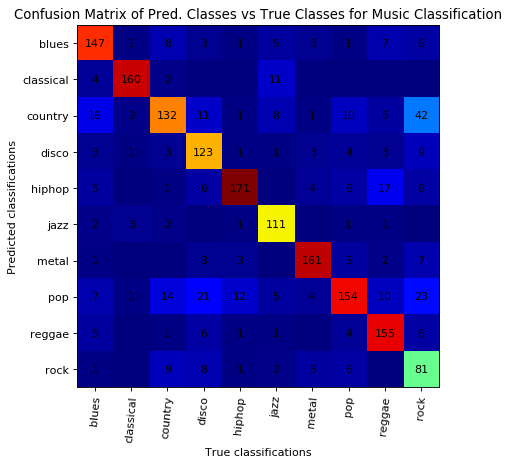

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# build_confusion_matrix()
# Builds the confusion matrix for either naive bayes' or logistic regression.
# Our goal is to have a strong diagonal which corresponds to good correlation
# between validation data classifications and our predictions.
# true_classes are the classifications for the predictions and classes are the total range of classes
def build_confusion_matrix(predictions, true_classes, classes, file_name):
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype='int')
    len_pred = len(predictions)
    print(true_classes)
    # for every class prediction and true class value
    for i in range(len_pred):
        true_classification = np.where(true_classes[i]==1)
#         print(true_classification)
        # we hope that these two are equal for a strong diagonal correlation
        confusion_matrix[predictions[i], true_classification] += 1

    confusion_matrix_df = pd.DataFrame(confusion_matrix, index= classes)
    axis_label = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(confusion_matrix_df.values, cmap='jet', interpolation='nearest')
    plt.xticks(np.arange(10), axis_label, rotation='85')
    plt.yticks(np.arange(10), axis_label)
    plt.tick_params(axis='both', labelsize='10')
    plt.xlabel("True classifications")
    plt.ylabel("Predicted classifications")
    plt.title("Confusion Matrix of Pred. Classes vs True Classes for Music Classification")
#     plt.tight_layout()
    for (j, i), label in np.ndenumerate(confusion_matrix):
        if label != 0:
            plt.text(i,j,label,ha='center',va='center', size='10')
    plt.show()

    confusion_matrix_df.to_csv(file_name, sep=",", header=classes)

model = load_model("models/best_model_3splits_mel.h5")
model.summary()

predictions = model.predict_classes(X_train_validation, verbose=1)
print(predictions)

build_confusion_matrix(predictions, y_train_validation, np.arange(0,10), "confusion_matrix_csv")


## Cross-validation neural network evaluating

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

num_of_folds = 10
total_examples = len(X_train)
size_of_one_fold = total_examples / 10

mcp = ModelCheckpoint("models/best_model_3splits_mel.h5", monitor='val_acc', verbose=0, 
                      save_best_only=True, save_weights_only=False, mode='max', period=1)

# adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)


# training[:(i-1) * 900] + training[i * 900:]
# validation[(i-1) * 900: i*900]

for i in range(1, num_of_folds+1):
#     print(X_train.shape)
    print("\nFold " + str(i))
    
    # do cross validation stuff
    
    X_train_fold = np.concatenate((X_train[:((i-1) * 900), :, :, :], X_train[(i * 900):, :, :, :]))
    y_train_fold = np.concatenate((y_train[:((i-1) * 900), :], y_train[(i * 900):, :]))
    
    X_train_validation_fold = X_train[((i-1) * 900) : (i * 900), :, :, :]
    y_train_validation_fold = y_train[((i-1) * 900) : (i * 900), :]
    print("Validation x train set:" + str(X_train_validation_fold.shape))
    print("X train set:" + str(X_train_fold.shape))
    print("Validation y train set:" + str(y_train_validation_fold.shape))
    print("Y train set:" + str(y_train_fold.shape) + "\n")
    
    # end cross-validation
    
    # get new model to train on
    model = build_model()
    
    model.compile(sgd, 'categorical_crossentropy',metrics=['accuracy'])
    
    model.fit(X_train_fold, y_train_fold, batch_size=32, epochs=3 , validation_data=(X_train_validation_fold, 
            y_train_validation_fold), callbacks = [mcp])